In [1]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
events_home_dir = '/home/vm01/Documents/fmri_project_copy/fmri_behavioral_data/'

events = get_events_file(events_home_dir, '03', 1)

In [131]:
subject_id = '02'
fmri_image = list()
mask_image = list()
for run in range(1, 11):
    if run%2 == 0:
        task = 'rotate'
    else:
        task = 'straight'
    fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    fmri_image.append(fmri_file)


In [5]:
def extract_prep_events_and_indices(events):
    #extracting prep events
    prep_events = events[events['trial_type'].str.contains('prep')].reset_index().drop('index', 1)

    #Renaming conditions column
    prep_events['target_location'] = '207'
    prep_events.loc[prep_events['trial_type'].str.contains('45'), 'target_location'] = '45'
    prep_events.loc[prep_events['trial_type'].str.contains('99'), 'target_location'] = '99'
    prep_events.loc[prep_events['trial_type'].str.contains('153'), 'target_location'] = '153'
    prep_events = prep_events.drop('trial_type', 1)
    prep_events = prep_events.sort_values(by='onset')
    indices = np.floor(prep_events['onset']/1.25).astype(int).values + 3

    return prep_events, indices

In [6]:
def extract_prep_images(indices, fmri_run_image):    
    #Extracting functionl images that correspond to prep times
    prep_images = image.index_img(fmri_run_image, np.ravel(np.vstack((indices, indices+1)), order = 'F'))
    return prep_images


In [7]:
accuracies = pd.DataFrame({'runs': np.repeat(np.arange(1, 11), 8),
                           'block_type': np.tile(np.repeat(['Straight', 'Rotate'], 8), 5),
                           'ROIs': np.tile(mask_names, 10),
                           '45': np.zeros(len(mask_names)*10),
                           '99': np.zeros(len(mask_names)*10),
                           '153': np.zeros(len(mask_names)*10),
                           '207': np.zeros(len(mask_names)*10),

                          })

In [7]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [46]:
atlas.labels

['Background',
 'GM Amygdala_centromedial group',
 'GM Amygdala_laterobasal group',
 'GM Amygdala_superficial group',
 'GM Anterior intra-parietal sulcus hIP1',
 'GM Anterior intra-parietal sulcus hIP2',
 'GM Anterior intra-parietal sulcus hIP3',
 "GM Broca's area BA44",
 "GM Broca's area BA45",
 'GM Hippocampus cornu ammonis',
 'GM Hippocampus dentate gyrus',
 'GM Hippocampus entorhinal cortex',
 'GM Hippocampus hippocampal-amygdaloid transition area',
 'GM Hippocampus subiculum',
 'GM Inferior parietal lobule PF',
 'GM Inferior parietal lobule PFcm',
 'GM Inferior parietal lobule PFm',
 'GM Inferior parietal lobule PFop',
 'GM Inferior parietal lobule PFt',
 'GM Inferior parietal lobule PGp',
 'GM Inferior parietal lobule Pga',
 'GM Insula Id1',
 'GM Insula Ig1',
 'GM Insula Ig2',
 'GM Lateral geniculate body',
 'GM Mamillary body',
 'GM Medial geniculate body',
 'GM Premotor cortex BA6',
 'GM Primary auditory cortex TE1.0',
 'GM Primary auditory cortex TE1.1',
 'GM Primary auditory 

In [132]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }


In [232]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

In [243]:
atlas.labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

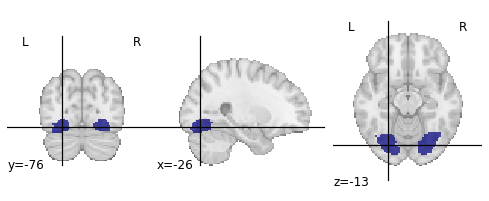

In [245]:
plotting.plot_roi(mask_image)

In [244]:
mask_image = image.new_img_like(atlas.maps, nilearn.image.get_data(atlas.maps) == 40)

In [173]:
resampled_mask = image.resample_to_img(mask_image, image.index_img(fmri_image[0], 1), interpolation='nearest')
#fmri_masked = masking.apply_mask(fmri_run_image, mask_img=resampled_mask)


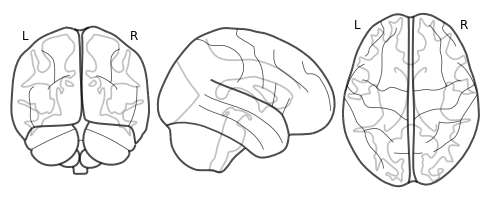

In [184]:
plot_glass_brain(image.index_img(resampled_mask, ))

In [180]:
masker = NiftiMasker(mask_img=image.resampled_mask, standardize=True)
masker.fit(image.index_img(fmri_image[0], 1))
fmri_masked = masker.transform(fmri_image[0])

ValueError: The mask is invalid as it is empty: it masks all data.

In [13]:
fmri_masked.shape

(360, 2304)

In [175]:
report = masker.generate_report()

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/reporting/html_report.py:184: UserWarning: This object has not been fitted yet ! Make sure to run `fit` before inspecting reports.
  warnings.warn('This object has not been fitted yet ! '


In [176]:
report

Parameter,Value


In [179]:
for run in range(1, 11):
    events = get_events_file(events_home_dir, '02', run)
    fmri_run_image = fmri_image[run-1]
    prep_events, indices = extract_prep_events_and_indices(events)
    prep_images = extract_prep_images(indices, fmri_run_image)
    
    for i in range(len(masks)):
        #nifti_masker = NiftiMasker(mask_img='masks/sub-02/'+masks[i], standardize=True)
        resampled_mask = image.resample_to_img('masks/sub-02/'+masks[i], prep_images, interpolation='nearest')

        #nifti_masker.fit(prep_images)
        #mask_image = nifti_masker.mask_img_
        #nifti_masker.fit(prep_images)
        #fmri_masked = nifti_masker.transform(prep_images)
        fmri_masked = masking.apply_mask(prep_images, mask_img=resampled_mask)
        #conditions = prep_events.target_location.values
        #decoder = Decoder(estimator='svc_l2', mask = nifti_masker, cv=5)
        #decoder.fit(prep_images, np.repeat(conditions, 2))
        #accuracies.loc[((accuracies['runs'] == run) & (accuracies['ROIs'] == mask_names[i]) ), '45'] = np.mean(decoder.cv_scores_['45'])
        #accuracies.loc[((accuracies['runs'] == run) & (accuracies['ROIs'] == mask_names[i]) ), '99'] = np.mean(decoder.cv_scores_['99'])
        #accuracies.loc[((accuracies['runs'] == run) & (accuracies['ROIs'] == mask_names[i]) ), '153'] = np.mean(decoder.cv_scores_['153'])
        #accuracies.loc[((accuracies['runs'] == run) & (accuracies['ROIs'] == mask_names[i]) ), '207'] = np.mean(decoder.cv_scores_['207'])
        print("Mask done: ", mask_names[i])
        
    #print(accuracies)
#dummy_decoder = Decoder(estimator='dummy_classifier', mask = nifti_masker)
#dummy_decoder.fit(prep_images, np.repeat(conditions, 2))



Mask done:  premotor_L
Mask done:  premotor_R


KeyboardInterrupt: 

In [260]:
accuracies = pd.read_csv('analyses_results/sub-02/blocked_decoding_accuracies.csv').drop('Unnamed: 0', 1)

In [261]:
accuracies_melt = accuracies.melt(id_vars=['runs', 'block_type', 'ROIs'], var_name = 'angle', value_name='decoding_accuracy')

In [160]:
accuracies.to_csv('analyses_results/sub-02/blocked_decoding_accuracies.csv')

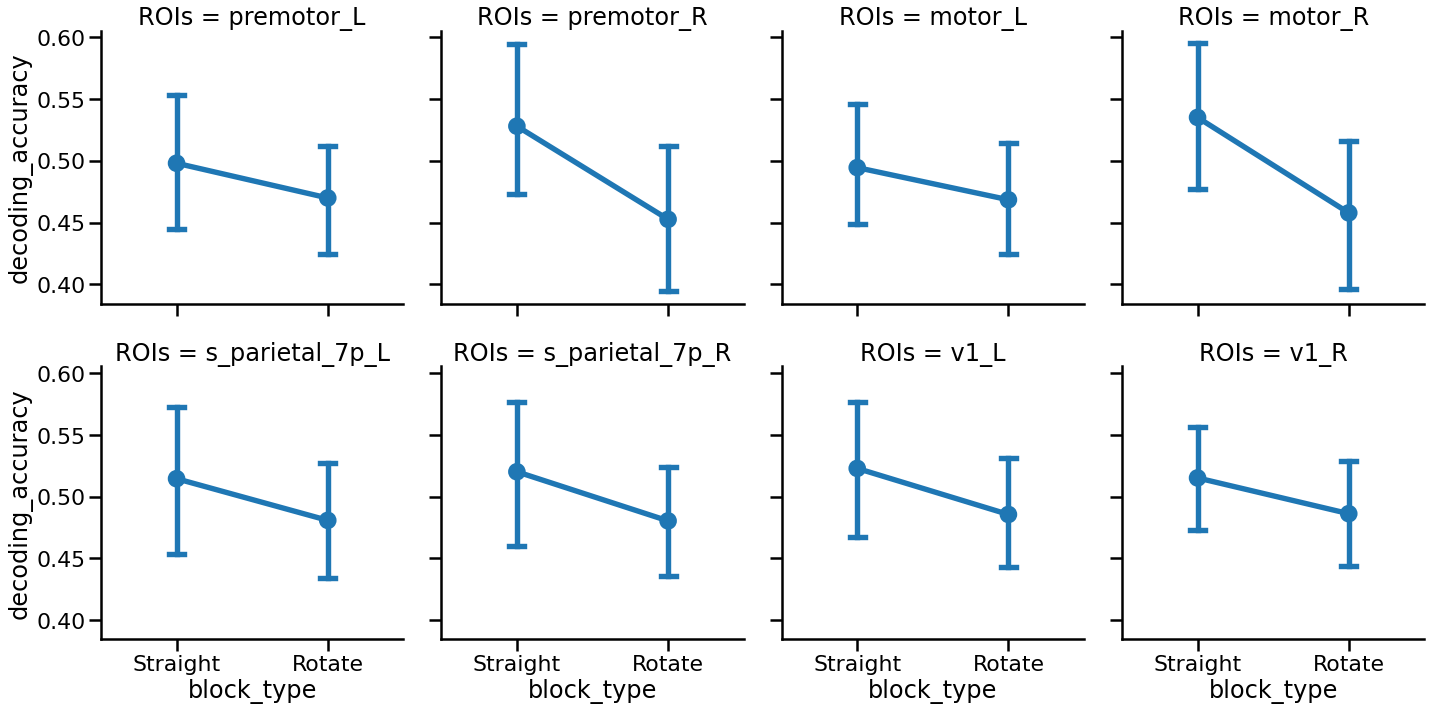

In [265]:
sns.catplot(x='block_type', y = 'decoding_accuracy',
            col = 'ROIs',col_wrap=4, 
            data = accuracies_melt, kind = 'point', capsize = 0.1)

## Voxel Correlations within and across dimensions 

In [ ]:

voxels_45 = np.mean(fmri_masked[np.where(np.repeat(conditions, 2) == '45')[0]], axis = 0)
voxels_99 = np.mean(fmri_masked[np.where(np.repeat(conditions, 2) == '99')[0]], axis = 0)
voxels_153 = np.mean(fmri_masked[np.where(np.repeat(conditions, 2) == '153')[0]], axis = 0)
voxels_207 = np.mean(fmri_masked[np.where(np.repeat(conditions, 2) == '207')[0]], axis = 0)


In [7]:
corrs = {}
for run in range(1, 11):
    events = get_events_file(events_home_dir, '02', run)
    fmri_run_image = fmri_image[run-1]
    prep_events, indices = extract_prep_events_and_indices(events)
    prep_images = extract_prep_images(indices, fmri_run_image)
    
    for i in range(len(masks)):
        #nifti_masker = NiftiMasker(mask_img='masks/sub-02/'+masks[i], standardize=True)
        resampled_mask = image.resample_to_img('masks/sub-02/'+masks[i], prep_images, interpolation='nearest')

        #nifti_masker.fit(prep_images)
        #mask_image = nifti_masker.mask_img_
        #nifti_masker.fit(prep_images)
        #fmri_masked = nifti_masker.transform(prep_images)
        fmri_masked = masking.apply_mask(prep_images, mask_img=resampled_mask)
        fmri_masked_avg = 0.5 * (fmri_masked[0::2] + fmri_masked[1::2]) #average of two consecutive time points
        d = pd.DataFrame(fmri_masked_avg, columns=np.arange(fmri_masked_avg.shape[1]))
        d['direction'] = prep_events.target_location.values
        d.set_index(keys = ['direction'],  inplace = True)
        dt = d.transpose()
        
        corrs[str(run) + '_' + masks[i]] = dt.corr() 
        
        print("Mask done: ", mask_names[i])
        
    print("Run Done: ", run)
#dummy_decoder = Decoder(estimator='dummy_classifier', mask = nifti_masker)
#dummy_decoder.fit(prep_images, np.repeat(conditions, 2))



Mask done:  premotor_L
Mask done:  premotor_R
Mask done:  motor_L
Mask done:  motor_R
Mask done:  s_parietal_7p_L
Mask done:  s_parietal_7p_R
Mask done:  v1_L
Mask done:  v1_R
Run Done:  1
Mask done:  premotor_L
Mask done:  premotor_R
Mask done:  motor_L
Mask done:  motor_R
Mask done:  s_parietal_7p_L
Mask done:  s_parietal_7p_R
Mask done:  v1_L
Mask done:  v1_R
Run Done:  2
Mask done:  premotor_L
Mask done:  premotor_R
Mask done:  motor_L
Mask done:  motor_R
Mask done:  s_parietal_7p_L
Mask done:  s_parietal_7p_R
Mask done:  v1_L
Mask done:  v1_R
Run Done:  3
Mask done:  premotor_L
Mask done:  premotor_R
Mask done:  motor_L
Mask done:  motor_R
Mask done:  s_parietal_7p_L
Mask done:  s_parietal_7p_R
Mask done:  v1_L
Mask done:  v1_R
Run Done:  4
Mask done:  premotor_L
Mask done:  premotor_R
Mask done:  motor_L
Mask done:  motor_R
Mask done:  s_parietal_7p_L
Mask done:  s_parietal_7p_R
Mask done:  v1_L
Mask done:  v1_R
Run Done:  5
Mask done:  premotor_L
Mask done:  premotor_R
Mask done

IndexError: index 321 is out of bounds for axis 3 with size 320

In [180]:
a = 0.5*(fmri_masked[0::2] + fmri_masked[1::2])

In [181]:
columns = np.arange(a.shape[1])

In [182]:
d = pd.DataFrame(a, columns=columns)

In [183]:
d['direction'] = prep_events.target_location.values

In [184]:
d.set_index(keys = ['direction'],  inplace = True)

In [185]:
dt = d.transpose()

In [192]:
corr.groupby('direction').median()

direction,153,153,153,153,153,153,153,153,153,153,...,99,99,99,99,99,99,99,99,99,99
direction,,,,,,,,,,,,,,,,,,,,,
153,0.984326,0.985525,0.995465,0.996469,0.983896,0.997856,0.997504,0.994205,0.997001,0.997241,...,0.997312,0.985704,0.986343,0.986395,0.985078,0.988884,0.987934,0.989450,0.990805,0.991888
207,0.997417,0.995368,0.986052,0.983586,0.997154,0.985193,0.984981,0.992680,0.983671,0.984188,...,0.983214,0.996942,0.996755,0.996442,0.996559,0.995514,0.993667,0.995728,0.993664,0.994763
45,0.988789,0.990065,0.994478,0.993193,0.988669,0.994591,0.993875,0.993706,0.993259,0.993600,...,0.993370,0.989999,0.990729,0.990803,0.989068,0.991847,0.989899,0.992515,0.991396,0.992372
99,0.996642,0.996121,0.988548,0.986824,0.996515,0.988237,0.988193,0.994431,0.987223,0.987830,...,0.986578,0.996916,0.997181,0.997210,0.996678,0.997154,0.995583,0.996772,0.996044,0.996580


['premotor', 'motor', 'v1', 'sup_parietal']

In [133]:
correlations = pd.DataFrame({'runs': np.repeat(np.arange(1, 11), len(masks)),
                           'block_type': np.tile(np.repeat(['Straight', 'Rotate'], len(masks)), 5),
                           'ROIs': np.tile(list(masks.keys()), 10),
                            '45_45': np.zeros(len(masks)*10),
                            '45_99': np.zeros(len(masks)*10),
                            '45_153': np.zeros(len(masks)*10),
                            '45_207': np.zeros(len(masks)*10),

                            '99_45': np.zeros(len(masks)*10),
                            '99_99': np.zeros(len(masks)*10),
                            '99_153': np.zeros(len(masks)*10),
                            '99_207': np.zeros(len(masks)*10),

                            '153_45': np.zeros(len(masks)*10),
                            '153_99': np.zeros(len(masks)*10),
                            '153_153': np.zeros(len(masks)*10),
                            '153_207': np.zeros(len(masks)*10),

                            '207_45': np.zeros(len(masks)*10),
                            '207_99': np.zeros(len(masks)*10),
                            '207_153': np.zeros(len(masks)*10),
                            '207_207': np.zeros(len(masks)*10),
                          })

In [13]:
run_no = '02'
beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/'
run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/')


In [14]:
z = image.load_img(os.path.join(beta_maps_dir, run_beta_maps[0]))

In [17]:
m = NiftiMasker()

In [18]:
a = m.fit_transform(z)

In [284]:
correlations.columns

Index(['runs', 'block_type', 'ROIs', '45_45', '45_99', '45_153', '45_207',
       '99_99', '99_153', '99_207', '153_153', '153_207', '207_207'],
      dtype='object')

In [220]:
for i, k in enumerate(np.sort(list(z_maps.keys()))):
    print (i, k)

0 153
1 207
2 45
3 99


In [134]:
subject_id = '02'
for run in range(1, 11):
    run_no = str(run).zfill(2)
    beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/'
    run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/')

    z_maps = {}

    for i in run_beta_maps:
        z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

    #Sorted by first number
    all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
    mean_image = image.mean_img(all_images)
    mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
    
    for i, key in enumerate(np.sort(list(z_maps.keys()))):
        z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

    for mask in masks.keys():
        even_dir_dict = {}
        odd_dir_dict = {}
        dir_dict = {}
        
        for direction in z_maps.keys():

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

            fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
            even = fmri_masked[0::2]
            odd = fmri_masked[1::2]
            
            #even_centered = even - np.mean(even, axis=0)
            #odd_centered = odd - np.mean(odd, axis = 0)
            
            
            even_dir_dict[direction] = np.mean(even, axis = 0)
            odd_dir_dict[direction] = np.mean(odd, axis = 0)
            dir_dict[direction] = np.mean(fmri_masked, axis = 0)
    
        for c in correlations.columns[3:]:
            even, odd = c.split('_')
            #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
            correlations.loc[((correlations['runs'] == run) & (correlations['ROIs'] == mask) ), c] = stat.pearsonr(even_dir_dict[even], odd_dir_dict[odd])[0] 
    print('Run Done: ', run)
    print(correlations)

Run Done:  1
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.000000  0.000000  0.000000  0.000000   
7      2     Rotate          motor  0.000000  0.000000  0.000000  0.000000   
8      2     Rotate             v1  0.000000  0.000000  0.000000  0.000000   
9      2     Rotate   sup_parietal  0.000000  0.000000  0.000000  0.000000   
10     2     Rotate   inf_parietal  0.000000  0.000000  0.000000  0.000000   
11     2     Rotate  somatosensory  0.000000  0.000

Run Done:  2
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  3
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  4
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  5
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  6
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  7
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  8
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  9
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.020

Run Done:  10
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.136091 -0.291663 -0.062543 -0.057467   
1      1   Straight          motor  0.076420 -0.267759 -0.030133 -0.167115   
2      1   Straight             v1  0.282797 -0.227737 -0.212677 -0.226678   
3      1   Straight   sup_parietal  0.312468 -0.335462 -0.012911 -0.108552   
4      1   Straight   inf_parietal  0.214418 -0.297148 -0.058524 -0.052083   
5      1   Straight  somatosensory  0.139874 -0.376511  0.061038 -0.011504   
6      2     Rotate       premotor  0.346983 -0.132635 -0.344306 -0.187694   
7      2     Rotate          motor  0.406381 -0.075197 -0.426271 -0.210147   
8      2     Rotate             v1  0.518920 -0.125436 -0.401849 -0.365611   
9      2     Rotate   sup_parietal  0.374712 -0.099351 -0.200852 -0.490603   
10     2     Rotate   inf_parietal  0.439658 -0.010707 -0.500413 -0.308464   
11     2     Rotate  somatosensory  0.345466 -0.02

In [250]:
dir_dict_straight

{}

In [253]:
masks[mask]

'GM Primary motor cortex BA4a'

In [135]:
bw_correlations = pd.DataFrame({'run_pairs': np.tile(np.arange(1, 6), len(masks)),
                           #'block_type': np.tile(np.repeat(['Straight', 'Rotate'], 8), 5),
                                'ROIs': np.repeat(list(masks.keys()), 5),
                                '45_45': np.zeros(len(masks)*5),
                                '45_99': np.zeros(len(masks)*5),
                                '45_153': np.zeros(len(masks)*5),
                                '45_207': np.zeros(len(masks)*5),
                                                               
                                '99_45': np.zeros(len(masks)*5),
                                '99_99': np.zeros(len(masks)*5),
                                '99_153': np.zeros(len(masks)*5),
                                '99_207': np.zeros(len(masks)*5),

                                '153_45': np.zeros(len(masks)*5),
                                '153_99': np.zeros(len(masks)*5),
                                '153_153': np.zeros(len(masks)*5),
                                '153_207': np.zeros(len(masks)*5),

                                '207_45': np.zeros(len(masks)*5),
                                '207_99': np.zeros(len(masks)*5),
                                '207_153': np.zeros(len(masks)*5),
                                '207_207': np.zeros(len(masks)*5),
                               
                               })

In [136]:
subject_id = '02'
for mask in masks.keys():
    mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])

    for run in range(1, 11):
        run_no = str(run).zfill(2)
        beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/'
        run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/')
        
        z_maps = {}
        
        for i in run_beta_maps:
            z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))
        
        all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'],z_maps['99']))
        mean_image = image.mean_img(all_images)
        mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)

        for i, key in enumerate(np.sort(list(z_maps.keys()))):
            z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))


        if run%2 != 0:
            dir_dict_straight = {}
            for direction in z_maps.keys():

                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                dir_dict_straight[direction] = np.mean(fmri_masked, axis = 0)
                
        else:
            
            dir_dict_rotate = {}
            for direction in z_maps.keys():
                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')
                #nifti_masker = NiftiMasker(mask_img=resampled_mask, standardize=True)

                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                dir_dict_rotate[direction] = np.mean(fmri_masked, axis = 0)
                
            for c in bw_correlations.columns[2:]:
                straight, rotate = c.split('_')
                #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
                bw_correlations.loc[((bw_correlations['run_pairs'] == int(run/2)) & (bw_correlations['ROIs'] == mask) ), c] = stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0]

        

    print('Run Done: ', run)
    print(bw_correlations)

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor -0.076817 -0.036472  0.176566 -0.049651   
1           2       premotor  0.191981  0.026468 -0.170162 -0.061491   
2           3       premotor  0.162903 -0.151681  0.001306 -0.043309   
3           4       premotor -0.158017 -0.064211  0.197334  0.036643   
4           5       premotor  0.117353 -0.110630 -0.002906  0.003141   
5           1          motor  0.000000  0.000000  0.000000  0.000000   
6           2          motor  0.000000  0.000000  0.000000  0.000000   
7           3          motor  0.000000  0.000000  0.000000  0.000000   
8           4          motor  0.000000  0.000000  0.000000  0.000000   
9           5          motor  0.000000  0.000000  0.000000  0.000000   
10          1             v1  0.000000  0.000000  0.000000  0.000000   
11          2             v1  0.000000  0.000000  0.000000  0.000000   
12          3             v1  0.000000  0.000000  

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor -0.076817 -0.036472  0.176566 -0.049651   
1           2       premotor  0.191981  0.026468 -0.170162 -0.061491   
2           3       premotor  0.162903 -0.151681  0.001306 -0.043309   
3           4       premotor -0.158017 -0.064211  0.197334  0.036643   
4           5       premotor  0.117353 -0.110630 -0.002906  0.003141   
5           1          motor -0.070956  0.072893  0.092564 -0.068089   
6           2          motor  0.194498 -0.147557 -0.060882  0.006635   
7           3          motor  0.142924 -0.184405  0.024239 -0.017467   
8           4          motor -0.218684 -0.114041  0.228516  0.123665   
9           5          motor  0.123680 -0.160880  0.044657  0.018021   
10          1             v1  0.133649  0.067324 -0.076902 -0.163643   
11          2             v1  0.223880 -0.051139 -0.112062 -0.072180   
12          3             v1  0.206610  0.026023 -

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor -0.076817 -0.036472  0.176566 -0.049651   
1           2       premotor  0.191981  0.026468 -0.170162 -0.061491   
2           3       premotor  0.162903 -0.151681  0.001306 -0.043309   
3           4       premotor -0.158017 -0.064211  0.197334  0.036643   
4           5       premotor  0.117353 -0.110630 -0.002906  0.003141   
5           1          motor -0.070956  0.072893  0.092564 -0.068089   
6           2          motor  0.194498 -0.147557 -0.060882  0.006635   
7           3          motor  0.142924 -0.184405  0.024239 -0.017467   
8           4          motor -0.218684 -0.114041  0.228516  0.123665   
9           5          motor  0.123680 -0.160880  0.044657  0.018021   
10          1             v1  0.133649  0.067324 -0.076902 -0.163643   
11          2             v1  0.223880 -0.051139 -0.112062 -0.072180   
12          3             v1  0.206610  0.026023 -

In [60]:
dir_dict_straight

{'99': array([ 0.5375381 , -0.15717296, -0.17063388, ..., -0.60097533,
        -0.25109434, -0.43383607], dtype=float32),
 '45': array([-0.6521193 ,  0.31357545,  0.03776479, ...,  0.29497892,
         0.502871  ,  0.38797528], dtype=float32),
 '153': array([ 0.34808367,  0.38709205,  0.24434535, ..., -0.22830959,
        -0.28561252, -0.1899503 ], dtype=float32),
 '207': array([-0.23350291, -0.5434946 , -0.11147635, ...,  0.53430605,
         0.03383543,  0.23581102], dtype=float32)}

In [137]:
correlations_melt = correlations.melt(id_vars=['runs', 'block_type', 'ROIs'], var_name = 'correlations', value_name='corr')

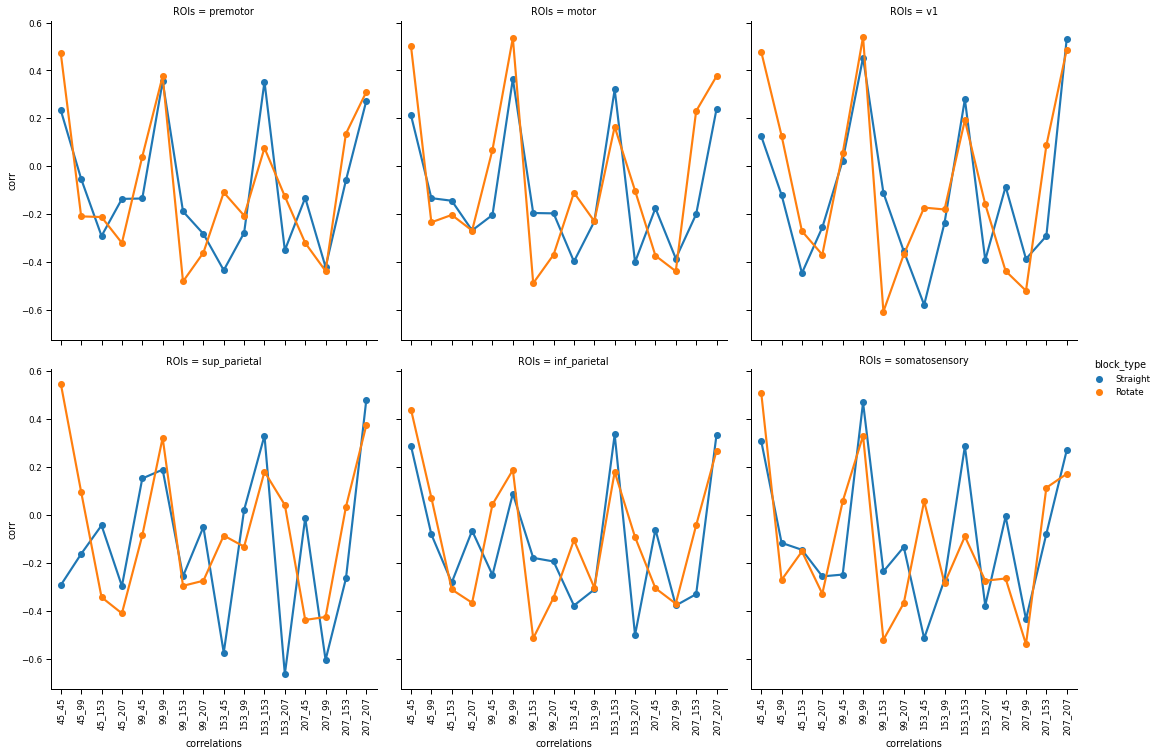

In [154]:
sns.set_context('paper')
g = sns.catplot(x = 'correlations', y = 'corr', hue = 'block_type', col = 'ROIs', col_wrap = 3,
                kind = 'point', data = correlations_melt.loc[correlations_melt['runs'] > 8], capsize = 0.1)

g.set_axis_labels().set_xticklabels(rotation = 90)

In [139]:
bw_correlations_melt = bw_correlations.melt(id_vars=['run_pairs',  'ROIs'], var_name = 'correlations', value_name='corr')

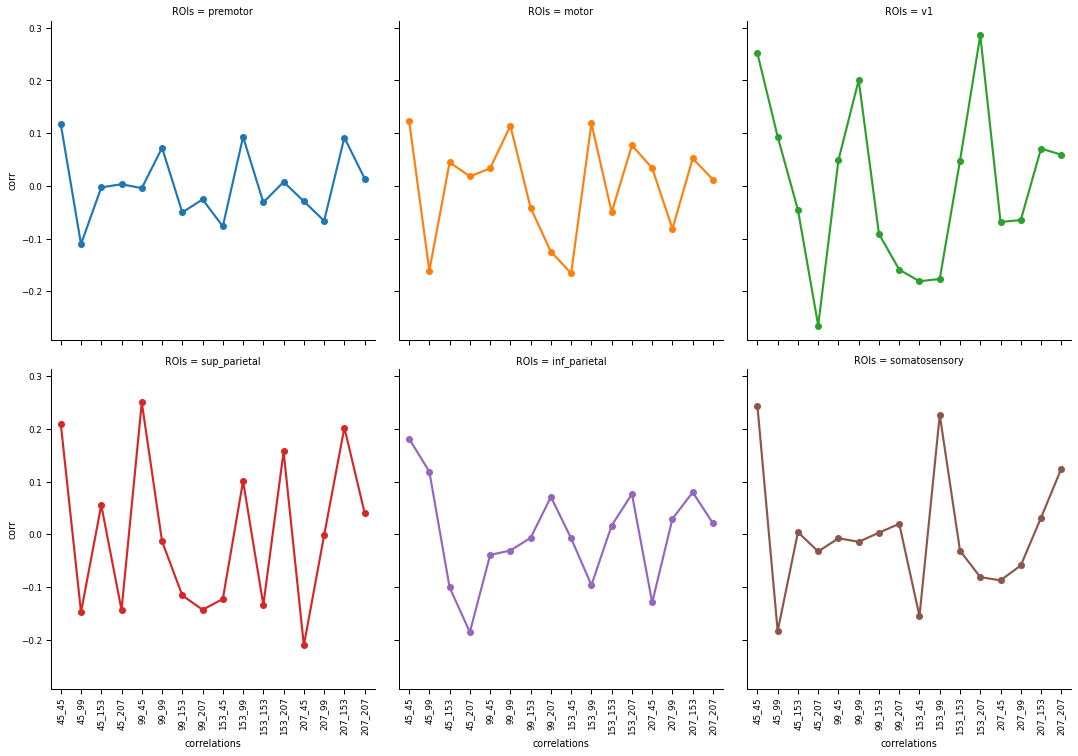

In [156]:
sns.set_context('paper')

ax = sns.catplot(x = 'correlations', y = 'corr', hue = 'ROIs', col = 'ROIs', col_wrap=3,
                 kind = 'point', data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] >= 5))], capsize = 0.1)

ax.set_axis_labels().set_xticklabels(rotation = 90)

In [142]:
aim = []
for i in bw_correlations_melt.correlations.str.split('_').values:
    aim.append((int(i[0]) - (int(i[1]) - 90)))

In [143]:
bw_correlations_melt['aim_diff'] = aim

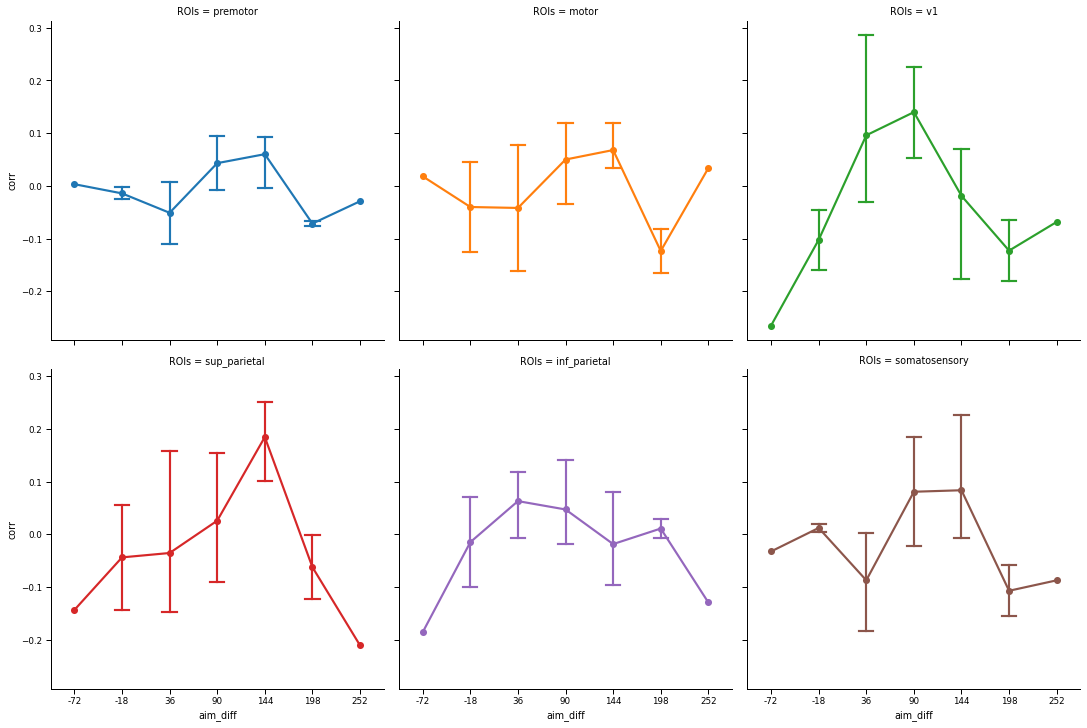

In [158]:
sns.catplot(x = "aim_diff", y = "corr", hue = 'ROIs', col = 'ROIs', col_wrap = 3,
            order = np.sort(np.unique(bw_correlations_melt['aim_diff'])),
            data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] == 5))], kind = 'point', capsize = 0.3)